In [1]:
import torch
from tqdm.auto import tqdm
import numpy as np
import random
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from torchvision.transforms import transforms
from timeit import default_timer as timer
from torch import nn

In [2]:
def walk_through_dir(dir_path):
    """
    Walks through dir_path returning its contents.
    Args:
    dir_path (str): target directory

    Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
    """
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(
            f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")


def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101),
                         np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(
        np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())


def plot_predictions(
    train_data, train_labels, test_data, test_labels, predictions=None
):
    """
  Plots linear training data and test data and compares predictions.
  """
    plt.figure(figsize=(10, 7))

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    # Plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    if predictions is not None:
        # Plot the predictions in red (predictions were made on the test data)
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    # Show the legend
    plt.legend(prop={"size": 14})


def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc


def print_train_time(start, end, device=None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format).
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"\nTrain time on {device}: {total_time:.3f} seconds")
    return total_time


def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()


# def pred_and_plot_image(
#     model: torch.nn.Module,
#     image_path: str,
#     class_names: List[str] = None,
#     transform=None,
#     device: torch.device = "cuda" if torch.cuda.is_available() else "cpu",
# ):
#     """Makes a prediction on a target image with a trained model and plots the image.

#     Args:
#         model (torch.nn.Module): trained PyTorch image classification model.
#         image_path (str): filepath to target image.
#         class_names (List[str], optional): different class names for target image. Defaults to None.
#         transform (_type_, optional): transform of target image. Defaults to None.
#         device (torch.device, optional): target device to compute on. Defaults to "cuda" if torch.cuda.is_available() else "cpu".

#     Returns:
#         Matplotlib plot of target image and model prediction as title.

#     Example usage:
#         pred_and_plot_image(model=model,
#                             image="some_image.jpeg",
#                             class_names=["class_1", "class_2", "class_3"],
#                             transform=torchvision.transforms.ToTensor(),
#                             device=device)
#     """

#     # 1. Load in image and convert the tensor values to float32
#     target_image = torchvision.io.read_image(
#         str(image_path)).type(torch.float32)

#     # 2. Divide the image pixel values by 255 to get them between [0, 1]
#     target_image = target_image / 255.0

#     # 3. Transform if necessary
#     if transform:
#         target_image = transform(target_image)

#     # 4. Make sure the model is on the target device
#     model.to(device)

#     # 5. Turn on model evaluation mode and inference mode
#     model.eval()
#     with torch.inference_mode():
#         # Add an extra dimension to the image
#         target_image = target_image.unsqueeze(dim=0)

#         # Make a prediction on image with an extra dimension and send it to the target device
#         target_image_pred = model(target_image.to(device))

#     # 6. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
#     target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

#     # 7. Convert prediction probabilities -> prediction labels
#     target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

#     # 8. Plot the image alongside the prediction and prediction probability
#     plt.imshow(
#         target_image.squeeze().permute(1, 2, 0)
#     )  # make sure it's the right size for matplotlib
#     if class_names:
#         title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
#     else:
#         title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
#     plt.title(title)
#     plt.axis(False)


def set_seeds(seed: int = 42):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)


# def download_data(source: str,
#                   destination: str,
#                   remove_source: bool = True) -> Path:
#     """Downloads a zipped dataset from source and unzips to destination.

#     Args:
#         source (str): A link to a zipped file containing data.
#         destination (str): A target directory to unzip data to.
#         remove_source (bool): Whether to remove the source after downloading and extracting.

#     Returns:
#         pathlib.Path to downloaded data.

#     Example usage:
#         download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
#                       destination="pizza_steak_sushi")
#     """
#     # Setup path to data folder
#     data_path = Path("data/")
#     image_path = data_path / destination

#     # If the image folder doesn't exist, download it and prepare it...
#     if image_path.is_dir():
#         print(f"[INFO] {image_path} directory exists, skipping download.")
#     else:
#         print(f"[INFO] Did not find {image_path} directory, creating one...")
#         image_path.mkdir(parents=True, exist_ok=True)

#         # Download pizza, steak, sushi data
#         target_file = Path(source).name
#         with open(data_path / target_file, "wb") as f:
#             request = requests.get(source)
#             print(f"[INFO] Downloading {target_file} from {source}...")
#             f.write(request.content)

#         # Unzip pizza, steak, sushi data
#         with zipfile.ZipFile(data_path / target_file, "r") as zip_ref:
#             print(f"[INFO] Unzipping {target_file} data...")
#             zip_ref.extractall(image_path)

#         # Remove .zip file
#         if remove_source:
#             os.remove(data_path / target_file)

#     return image_path


def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format).
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

# ---------------------------------------------------------------------------------------------------

In [3]:
import cv2
import imghdr
data_dir = 'D:\Projects\Python\Dog_Emotion\dataset\\final' 
image_exts = ['jpeg','jpg', 'bmp', 'png']
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

In [4]:
    from PIL import Image
    import torch
    from torch.utils.data import Dataset
    import torchvision.transforms as transforms
    import os

    class EmotionDataset(Dataset):
        def __init__(self, dataset_path):
            self.dataset_path = dataset_path
            self.food_categories = sorted(os.listdir(dataset_path))
            self.class_to_idx = {category: i for i, category in enumerate(self.food_categories)}
            self.images, self.labels = self._load_dataset()
            self.transform = transforms.Compose([
                transforms.Resize((256, 256)),
                transforms.ToTensor()
            ])

        def __len__(self):
            return len(self.images)

        def __getitem__(self, index):
            image_path = self.images[index]
            label = self.labels[index]

            image = Image.open(image_path)
            
            # Resize image to 3x256x256
            image = self.transform(image)

            return image, torch.tensor(label)

        def _load_dataset(self):
            dataset = []
            labels = []

            for category_idx, category in enumerate(tqdm(self.food_categories)):
                category_path = os.path.join(self.dataset_path, category)
                image_files = os.listdir(category_path)

                # Exclude the .DS_Store file if it exists
                if ".DS_Store" in image_files:
                    image_files.remove(".DS_Store")

                for image_file in image_files:
                    image_path = os.path.join(category_path, image_file)
                    dataset.append(image_path)
                    labels.append(category_idx)  # Assign category index as label

            return dataset, labels

    # Example usage
    dataset_path = r"D:\Projects\Python\Dog_Emotion\dataset\final-Gray-scale"
    emotion_dataset = EmotionDataset(dataset_path)

    # Get an image and label from the dataset
    image, label = emotion_dataset[0]

    # Print the number of classes
    num_classes = len(emotion_dataset.food_categories)
    print("Number of classes:", num_classes)

    # Print the number of images in the dataset
    num_images = len(emotion_dataset)
    print("Number of images:", num_images)

    # Verify the size of the image tensor
    print("Image shape:", image.shape)



Number of classes: 3
Number of images: 334
Image shape: torch.Size([1, 256, 256])


In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# Set the maximum memory limit in bytes (4 GB in this case)
max_memory_limit = 2 * 1024 * 1024 * 1024  # 4 GB

# Check the initial memory allocation
initial_memory_allocated = torch.cuda.memory_allocated()
print("Initial memory allocated:", initial_memory_allocated)
§
# Perform your training or inference operations

# Empty the GPU cache to release unused memory
torch.cuda.empty_cache()

# Set the memory limit
torch.cuda.set_per_process_memory_fraction(0.6)  # Set to 60% of GPU memory

# Check the memory usage after operations
final_memory_allocated = torch.cuda.memory_allocated()
print("Final memory allocated:", final_memory_allocated/1000000)
if torch.cuda.is_available():
    print("CUDA is available")
    device = torch.device("cuda")
    print("GPU:", torch.cuda.get_device_name(device))
else:
    print("CUDA is not available")

Initial memory allocated: 0
Final memory allocated: 0.0
CUDA is available
GPU: NVIDIA GeForce GTX 1650 Ti


In [6]:
food_categories = sorted(os.listdir(dataset_path))
category_dict = {}

for category_idx, category in enumerate(food_categories):
    category_dict[category_idx] = category

print(category_dict)

{0: 'angry_face', 1: 'happy_face', 2: 'sad_face'}


In [7]:
import torch
from torch.utils.data import DataLoader, random_split

# Rest of the code for the FoodDataset class...

# Set the desired train-test split ratio
train_ratio = 0.8  # 80% of the data for training, 20% for testing
dataset_size = len(emotion_dataset)
train_size = int(train_ratio * dataset_size)
test_size = dataset_size - train_size

# Split the dataset into training and testing sets
train_dataset, test_dataset = random_split(emotion_dataset, [train_size, test_size])

# Create data loaders for the training and testing datasets
batch_size = 8  # Set your desired batch size
shuffle = True   # Set to True if you want to shuffle the training data
num_workers = 0  # Set the number of worker processes for loading the data (usually set to the number of CPU cores)

train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

torch.Size([1, 256, 256])


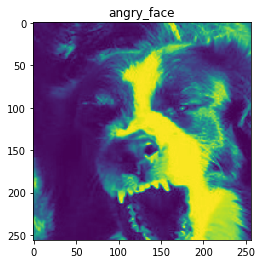

torch.Size([1, 256, 256])


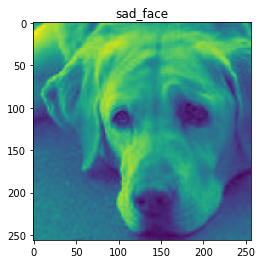

torch.Size([1, 256, 256])


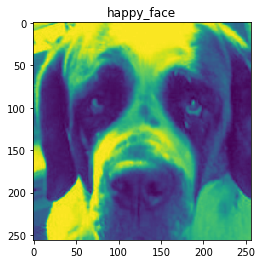

torch.Size([1, 256, 256])


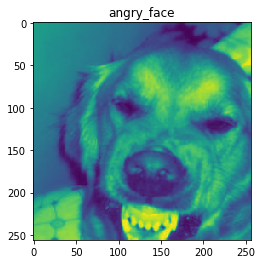

torch.Size([1, 256, 256])


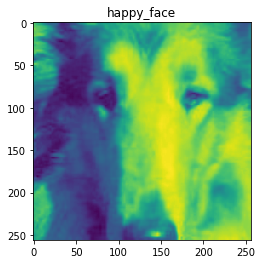

In [8]:
for f1 in range(5):
    index = random.randint(0, len(train_dataset) - 1)
    image, label = train_dataset[index]
    print(image.shape)
    plt.imshow(image.permute(1,2,0).squeeze().detach().numpy())
    plt.title(category_dict[int(label)])
    plt.show()

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=0)
        # self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=0)
        # self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.conv3 = nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=0)
        # self.relu3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(14400, 256)
        # self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(256, 3)  # Output size is 3 for three classes
        self.softmax = nn.Softmax(dim=1)  # Apply softmax activation for multi-class classification

    def forward(self, x):
        x = self.conv1(x)
        # x = self.relu1(x)
        x = self.maxpool1(x)
        # print(x.shape)
        # plt.imshow(x[0][0].squeeze(0).to('cpu').detach().numpy())
        # plt.title('block 2')
        # plt.show()
        x = self.conv2(x)
        # x = self.relu2(x)
        x = self.maxpool2(x)
        # print(x.shape)
        # plt.imshow(x[0][0].squeeze(0).to('cpu').detach().numpy())
        # plt.title('block 2')
        # plt.show()
        x = self.conv3(x)
        # x = self.relu3(x)
        x = self.maxpool3(x)
        # print(x.shape)
        # plt.imshow(x[0][0].squeeze(0).to('cpu').detach().numpy())
        # plt.title('block 2')
        # plt.show()
        x = self.flatten(x)
        x = self.fc1(x)
        # x = self.relu4(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

# Create an instance of the model
model = Model()

# Define the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.0001)

# Print the model summary
print(model)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Compile is not required in PyTorch as it is specific to TensorFlow


Model(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=14400, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=3, bias=True)
  (softmax): Softmax(dim=1)
)


Model(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=14400, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=3, bias=True)
  (softmax): Softmax(dim=1)
)

In [10]:
class Food_Classification(nn.Module):

    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,  # how big is the square that's going over the image?
                      stride=1,  # default
                      padding=1),  # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            # nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.ReLU()
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            # nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.block_3 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            # nn.MaxPool2d(kernel_size=2, stride=2),
            # nn.ReLU(),
        )
        self.block_4 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.Conv2d(hidden_units, 8, 3, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # nn.ReLU(),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from?
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=32768,
                      out_features=output_shape),
        )

    def forward(self, x: torch.Tensor):
        # plt.imshow(x[0].to('cpu').detach().numpy())
        # plt.title('Initial image')
        # plt.show()
        x = self.block_1(x)
        # print(x.shape)
        # plt.imshow(x[0][0].squeeze(0).to('cpu').detach().numpy())
        # plt.title('block 1')
        # plt.show()
        x = self.block_2(x)
        # print(x.shape)
        # plt.imshow(x[0][0].squeeze(0).to('cpu').detach().numpy())
        # plt.title('block 2')
        # plt.show()
        x = self.block_3(x)
        # print(x.shape)
        # plt.imshow(x[0][0].squeeze(0).to('cpu').detach().numpy())
        # plt.title('block 3')
        # plt.show()
        x = self.block_4(x)
        # print(x.shape)
        # plt.imshow(x[0][0].squeeze(0).to('cpu').detach().numpy())
        # plt.title('block 4')
        # plt.show()
        x = self.classifier(x)
        # print(x.shape)
        x = x.squeeze()
        return x



output_shape = 3
model = Food_Classification(3, 16, output_shape).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.001)

In [11]:
import torch
import torch.nn as nn

class VGG16(nn.Module):
    def __init__(self, num_classes=3):
        super(VGG16, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Softmax()
            # nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(12544, 1568),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(1568, 784),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(784, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

model = VGG16()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.5)

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim

class ModifiedVGG16(nn.Module):
    def __init__(self, num_classes=3):
        super(ModifiedVGG16, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, 32, kernel_size=5, padding=2),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(256 * 7 * 7, 512),
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.Dropout(),
            nn.Linear(512, num_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Create an instance of the ModifiedVGG16 model
model = ModifiedVGG16()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models


class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # Downsample layer for shortcut connection if needed
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.downsample = None
    
    def forward(self, x):
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        if self.downsample is not None:
            identity = self.downsample(x)
        
        out += identity
        out = self.relu(out)
        
        return out


class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=3):
        super(ResNet, self).__init__()
        self.in_channels = 64
        
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self.make_layer(block, 64, layers[0])
        self.layer2 = self.make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self.make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self.make_layer(block, 512, layers[3], stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
    
    def make_layer(self, block, out_channels, blocks, stride=1):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)
        
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        
        return out


# Create an instance of the ResNet model
model = ResNet(ResidualBlock, [2, 2, 2, 2])

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9) 

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim

class LeNet5(nn.Module):
    def __init__(self, num_classes=3):
        super(LeNet5, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, kernel_size=5),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(59536, 120),
            nn.Tanh(),
            nn.Linear(120, 84),
            nn.Tanh(),
            nn.Linear(84, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Create an instance of the LeNet5 model
model = LeNet5()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [10]:
model.to(device)
for batch in train_data_loader:
    X, y = batch
    model.eval()
        # 1. Forward pass
    y_pred = model(X.to(device))
    print(y_pred)
    print(y)
    break

tensor([[0.3265, 0.3255, 0.3480],
        [0.3227, 0.3241, 0.3532],
        [0.3206, 0.3255, 0.3539],
        [0.3244, 0.3243, 0.3513],
        [0.3235, 0.3229, 0.3536],
        [0.3266, 0.3204, 0.3530],
        [0.3249, 0.3242, 0.3509],
        [0.3270, 0.3218, 0.3511]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([2, 1, 1, 0, 0, 2, 2, 1])


In [31]:
import torchvision.models as models
class FineTunedModel(nn.Module):
    def __init__(self, num_classes):
        super(FineTunedModel, self).__init__()
        self.base_model = models.resnet18(pretrained=True)
        in_features = self.base_model.fc.in_features
        self.base_model.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.base_model(x)

# Step 4: Train the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FineTunedModel(num_classes=3)  # 3 emotions: angry, happy, sad
model = model.to(device)

In [11]:
import torch.optim as optim
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:

# decay_steps = 30
# initial_lr = 0.01
# decay_rate = 0.9
# best_accuracy = 0.0
epochs = 30
print(torch.cuda.max_memory_allocated())
model.to(device)
# Create training and testing loop
for epoch in tqdm(range(epochs)):
    # Training
    train_loss = 0
    t = 0
    # Add a loop to loop through training batches
    for batch in tqdm(train_data_loader):    
        X, y = batch
        model.train()
        # 1. Forward pass
        y_pred = model(X.to(device))
        probabilities = torch.sigmoid(y_pred)
        y_new_shape = torch.zeros(len(y), 3)
        for f1 in range(len(y)):
            y_new_shape[f1][y[f1]] = 1
        # print(probabilities)
        # print(y_new_shape)
        # print(f"probabilities are {probabilities}")
        # print(f"probabilities.shape is {probabilities.shape}")
        # print(f"y_new_shape is {y_new_shape}")
        # print(f"y_new_shape.shape is {y_new_shape.shape}")
        # 2. Calculate loss (per batch)
        loss = loss_fn(probabilities.to('cpu'), y_new_shape.to('cpu'))

            # Compute L2 regularization loss



        train_loss += loss  # accumulatively add up the loss per epoch

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()
        # print(f"Datatype of batch is {type(batch)}")
        # Print out how many samples have been seen
        t += 1
        # print(f"y_new_shape is : {y_new_shape} and y_preds are {y_pred}")

    # Divide total train loss by length of train dataloader (average loss per batch per epoch)
    train_loss /= len(train_data_loader)
    # # Dynamic learning rate
    # lr = initial_lr * (decay_rate ** (epoch // decay_steps))
    # for param_group in optimizer.param_groups:
    #     param_group['lr'] = lr
    # Testing
    # Setup variables for accumulatively adding up loss and accuracy
    test_loss, test_acc = 0, 0
    with torch.inference_mode():
        model.eval()
        for batch in test_data_loader:
            X, y = batch
            # 1. Forward pass
            test_pred = model(X.to(device))
            probabilities = torch.sigmoid(test_pred)
            # 2. Calculate loss (accumatively)
            # accumulatively add up the loss per epoch
            y_new_shape = torch.zeros(len(y), 3)
            for f1 in range(len(y)):
                y_new_shape[f1][y[f1]] = 1
            # print(f"y is {y}")
            # print(f"pred len is {len(y)}")
            # print(f"probabilities are {probabilities}")
            # print(f"probabilities.shape is {probabilities.shape}")
            # print(f"y_new_shape is {y_new_shape}")
            # print(f"y_new_shape.shape is {y_new_shape.shape}")

            
            test_loss += loss_fn(probabilities.to('cpu'), y_new_shape.to('cpu'))
            test_acc += accuracy_fn(y_true=y.to('cpu'),
                            y_pred=test_pred.argmax(dim=1).to('cpu'))

            # Calculations on test metrics need to happen inside torch.inference_mode()
            # Divide total test loss by length of test dataloader (per batch)
        test_loss /= len(test_data_loader)

        # Divide total accuracy by length of test dataloader (per batch)
        test_acc /= len(test_data_loader)

        # Print out what's happening
        # print(
        #     f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}\n")
    print(
        f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")


In [ ]:
test_loss, test_acc = 0, 0
with torch.inference_mode():
    model.eval()
    for batch in tqdm(test_data_loader):
        X, y = batch
        # 1. Forward pass
        test_pred = model(X.to(device))
        probabilities = torch.sigmoid(test_pred)
        # 2. Calculate loss (accumatively)
        # accumulatively add up the loss per epoch
        y_new_shape = torch.zeros(len(y), 4)
        for f1 in range(len(y)):
            y_new_shape[f1][y[f1]] = 4
        # print(f"y is {y}")
        # print(f"pred len is {len(y)}")
        # print(f"probabilities are {probabilities}")
        # print(f"probabilities.shape is {probabilities.shape}")
        # print(f"y_new_shape is {y_new_shape}")
        # print(f"y_new_shape.shape is {y_new_shape.shape}")
        
        try:
            test_loss += loss_fn(test_pred.to('cpu'), y_new_shape.to('cpu'))
        except:
            test_loss += loss_fn(test_pred.to('cpu'), y_new_shape.squeeze(dim=0).to('cpu'))
        try:
            test_acc += accuracy_fn(y_true=y.to('cpu'),
                        y_pred=test_pred.argmax(dim=1).to('cpu'))
        except:
            pass

In [45]:
torch.save(model,"model.pth")